# Imports and setup

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
cmap = plt.get_cmap('cmr.rainforest')
mpl.rc('image', cmap=cmap.name)

In [3]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [5]:
data

phi1,phi2,pm1,pm1_err,pm2,pm2_err
float64,float64,float64,float64,float64,float64
-76.68796785337894,-6.8080949806818065,-3.0384515074890235,0.15153440888627143,0.13028292210077425,0.16182445062011536
-76.67153834700639,-6.665433199587468,-2.2582323337603776,0.46166098296687075,1.0349279958585127,0.49332541499318694
-76.57957466677934,-6.76048258362525,-2.2614183542776867,0.1972117012260068,-3.9085758174893983,0.20385326523324485
-76.60641078588826,-6.485136366850281,-5.558766181872265,0.16298789406582684,5.194420616548316,0.20422171492181063
-76.39729230789541,-6.861364171958314,-11.973343391850369,0.10644831343003615,-5.964741296888041,0.12040237558355044
-76.37814058685453,-6.870849595636755,-4.71955573643114,0.11765376952817368,-0.932097595755368,0.1330001921024648
-76.40783448237958,-6.75795894038524,-2.9401845542771894,0.4687377714336541,-2.7688481693542872,0.48889761886576816
-76.3050908222849,-6.889047988456025,-4.636978331864595,0.3310994693913258,-1.631301630542096,0.40783339833087917
-76.35870141205838,-6.647992761313242,-9.312472633850106,0.11643934449025678,-5.381190877667894,0.1378426760446166


In [16]:
# data = at.Table.read("../../cats/data/joined-GD-1.fits")

data = at.Table.read('../data/run_data.fits')
masks = at.Table.read('../data/run_data_masks.fits')
print(len(data))

28507


In [17]:
run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
len(bkg_data['phi1'])

23859

In [18]:
len(bkg_data['phi1'])

23859

In [19]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

In [22]:
%matplotlib inline

In [23]:
plot_data_projections(data=run_data, grids=GD1BackgroundModel.default_grids,
                      smooth=1);

# Background

In [24]:
phi1_dens, _ = np.histogram(
    bkg_data["phi1"],
    bins=(GD1BackgroundModel.phi1_locs.shape[0]-1), density=True)


phi1_dens

array([0.00916899, 0.00678243, 0.0072603 , 0.00779127, 0.00814618,
       0.00823561, 0.00895381, 0.01033713])

In [46]:
bkg_init_p = {
    "ln_N": np.log(len(run_data['phi1'])),
    "phi1": {"zs": np.zeros(GD1BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(GD1BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm1_knots, 1),
        "ln_std1": np.full_like(GD1BackgroundModel.pm1_knots, 1),
        "mean2": np.full_like(GD1BackgroundModel.pm1_knots, 5.),
        "ln_std2": np.full_like(GD1BackgroundModel.pm1_knots, 2.)
    },
    "pm2": {
        "w": np.full_like(GD1BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm2_knots, 0),
        "ln_std1": np.full_like(GD1BackgroundModel.pm2_knots, 1.),
        "mean2": np.full_like(GD1BackgroundModel.pm2_knots, 0),
        "ln_std2": np.full_like(GD1BackgroundModel.pm2_knots, 2)
    },
}
background_init = GD1BackgroundModel(bkg_init_p)

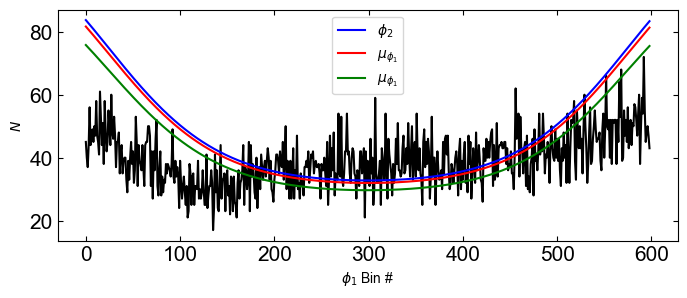

In [47]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_1}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [43]:
print(np.sum(np.exp(ln_ns['phi1','pm2'])))
print(np.sum(H_data1))

25519.64347538251
23604.0


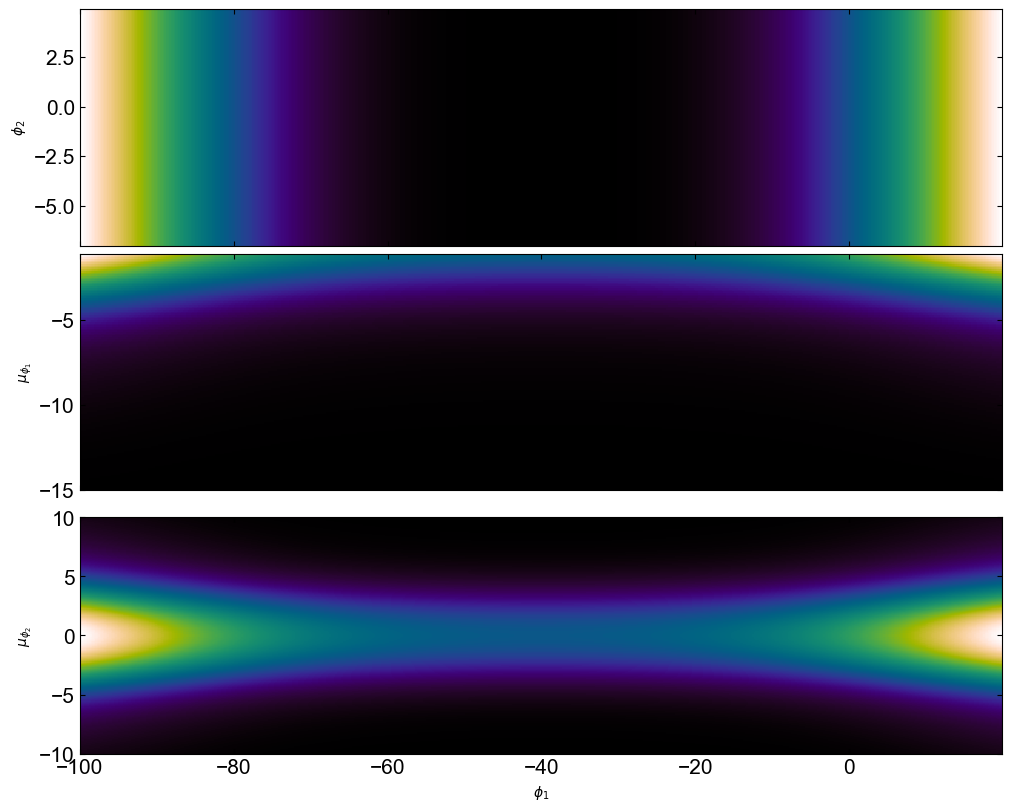

In [29]:
_ = background_init.plot_model_projections()

In [30]:
bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = GD1BackgroundModel(bkg_opt_pars)
bkg_info

ScipyMinimizeInfo(fun_val=Array(2.40099619, dtype=float64, weak_type=True), success=True, status=0, iter_num=2410, hess_inv=LbfgsInvHessProduct(sk=[[-4.19246972e-06  2.55093901e-03 -1.89761334e-03 ... -2.16363608e-04
   8.26156128e-05  6.71182705e-05]
 [-2.75342763e-06  1.27407169e-03 -9.41129064e-04 ... -7.75530053e-05
   3.66369521e-05 -6.88621364e-05]
 [-3.10715070e-05  1.00973835e-03 -6.66559722e-04 ... -2.52738833e-04
   1.23840285e-04  1.18742934e-04]
 ...
 [-3.69016644e-05  7.88310805e-05 -1.82248495e-04 ...  5.03798906e-05
  -6.41453019e-05 -3.21818454e-05]
 [ 8.09306470e-05  8.78443759e-04 -1.26896270e-03 ...  2.07611035e-04
  -1.67271527e-04 -8.41028422e-05]
 [ 2.89014751e-05  1.33452592e-03 -1.21253578e-03 ...  8.41380103e-06
  -1.53840024e-05 -4.52588997e-06]], yk=[[-4.19263837e-06  9.53463604e-06  1.32612665e-05 ... -3.68318969e-06
   1.30855425e-05  1.47800976e-05]
 [-2.75352883e-06  5.39294447e-06  7.72457960e-06 ...  2.47893869e-05
  -3.73753694e-06 -2.35754488e-05]
 [-

In [31]:
bkg_opt_pars

{'ln_N': Array(10.08001521, dtype=float64),
 'phi1': {'zs': Array([-0.53017049,  0.0543069 , -8.        ,  0.43845126,  0.49905581,
          0.10179089,  0.89194887,  0.13813535], dtype=float64)},
 'phi2': {},
 'pm1': {'ln_std1': Array([1.04668942, 1.40616429, 1.5897183 , 1.24675471, 1.38687284,
         1.02700879, 0.66521155, 0.83550808, 0.49397497, 0.686158  ,
         1.57234458, 1.31015647, 0.547617  ], dtype=float64),
  'ln_std2': Array([1.67003304, 1.5555211 , 0.77206459, 0.        , 1.28771453,
         1.13808893, 0.98606098, 1.13719123, 1.39622833, 1.85052474,
         1.92257703, 1.33350765, 1.99579688], dtype=float64),
  'mean1': Array([10.43727521, 12.83004538, 20.        ,  8.02119338,  6.15989531,
          3.16904855,  0.31010463,  1.96469851,  0.45638355,  2.5505432 ,
         15.24657958,  7.94268099, -0.37568135], dtype=float64),
  'mean2': Array([11.13891846, 13.74589045,  5.56435389, -1.54926809, -0.32194696,
         -1.73430963, -4.83739832, -3.03442333, -0.3301

In [32]:
bkg_opt_pars['pm1']['w']

Array([0.27786035, 0.64400337, 0.47173503, 0.54154308, 0.85058637,
       0.63909011, 0.66111486, 0.47860736, 0.32438734, 0.14116772,
       0.30055988, 0.50604141, 0.62198125], dtype=float64)

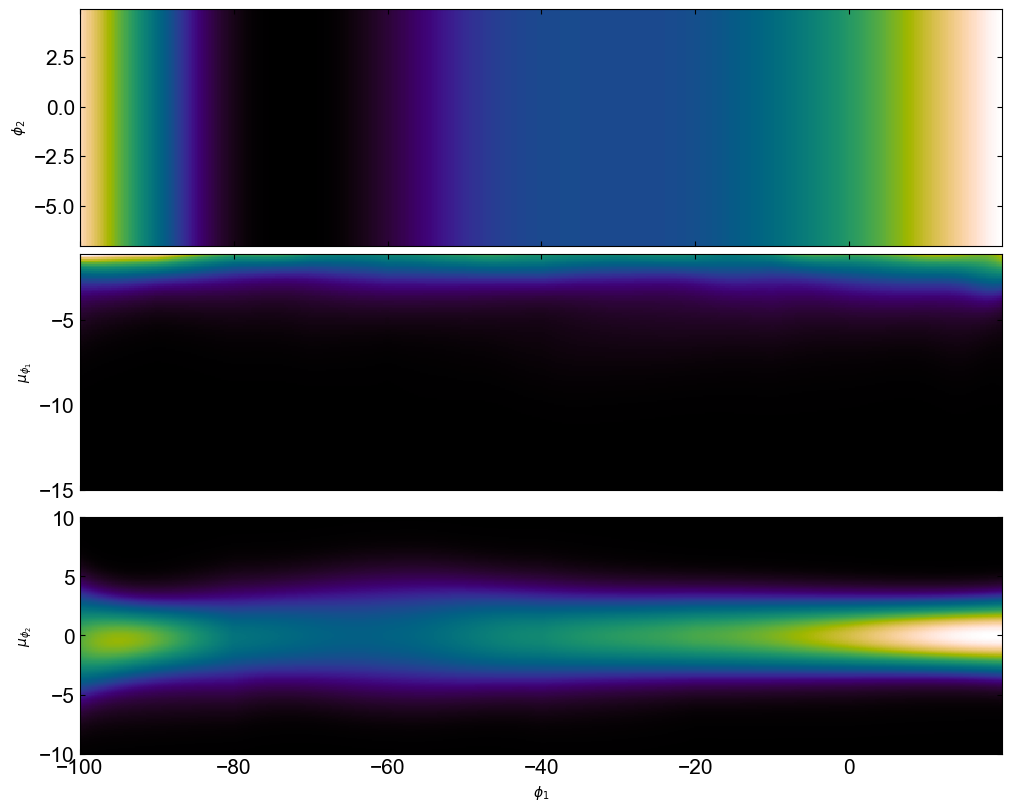

In [34]:
_ = background_opt.plot_model_projections()

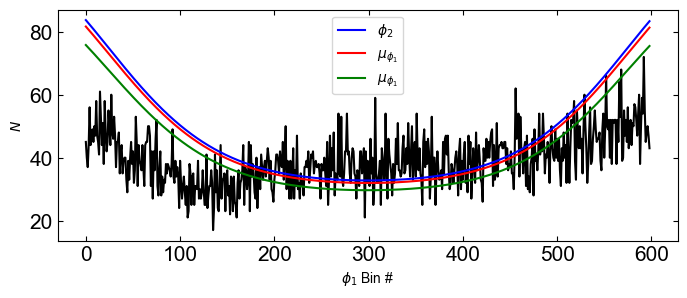

In [35]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_1}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

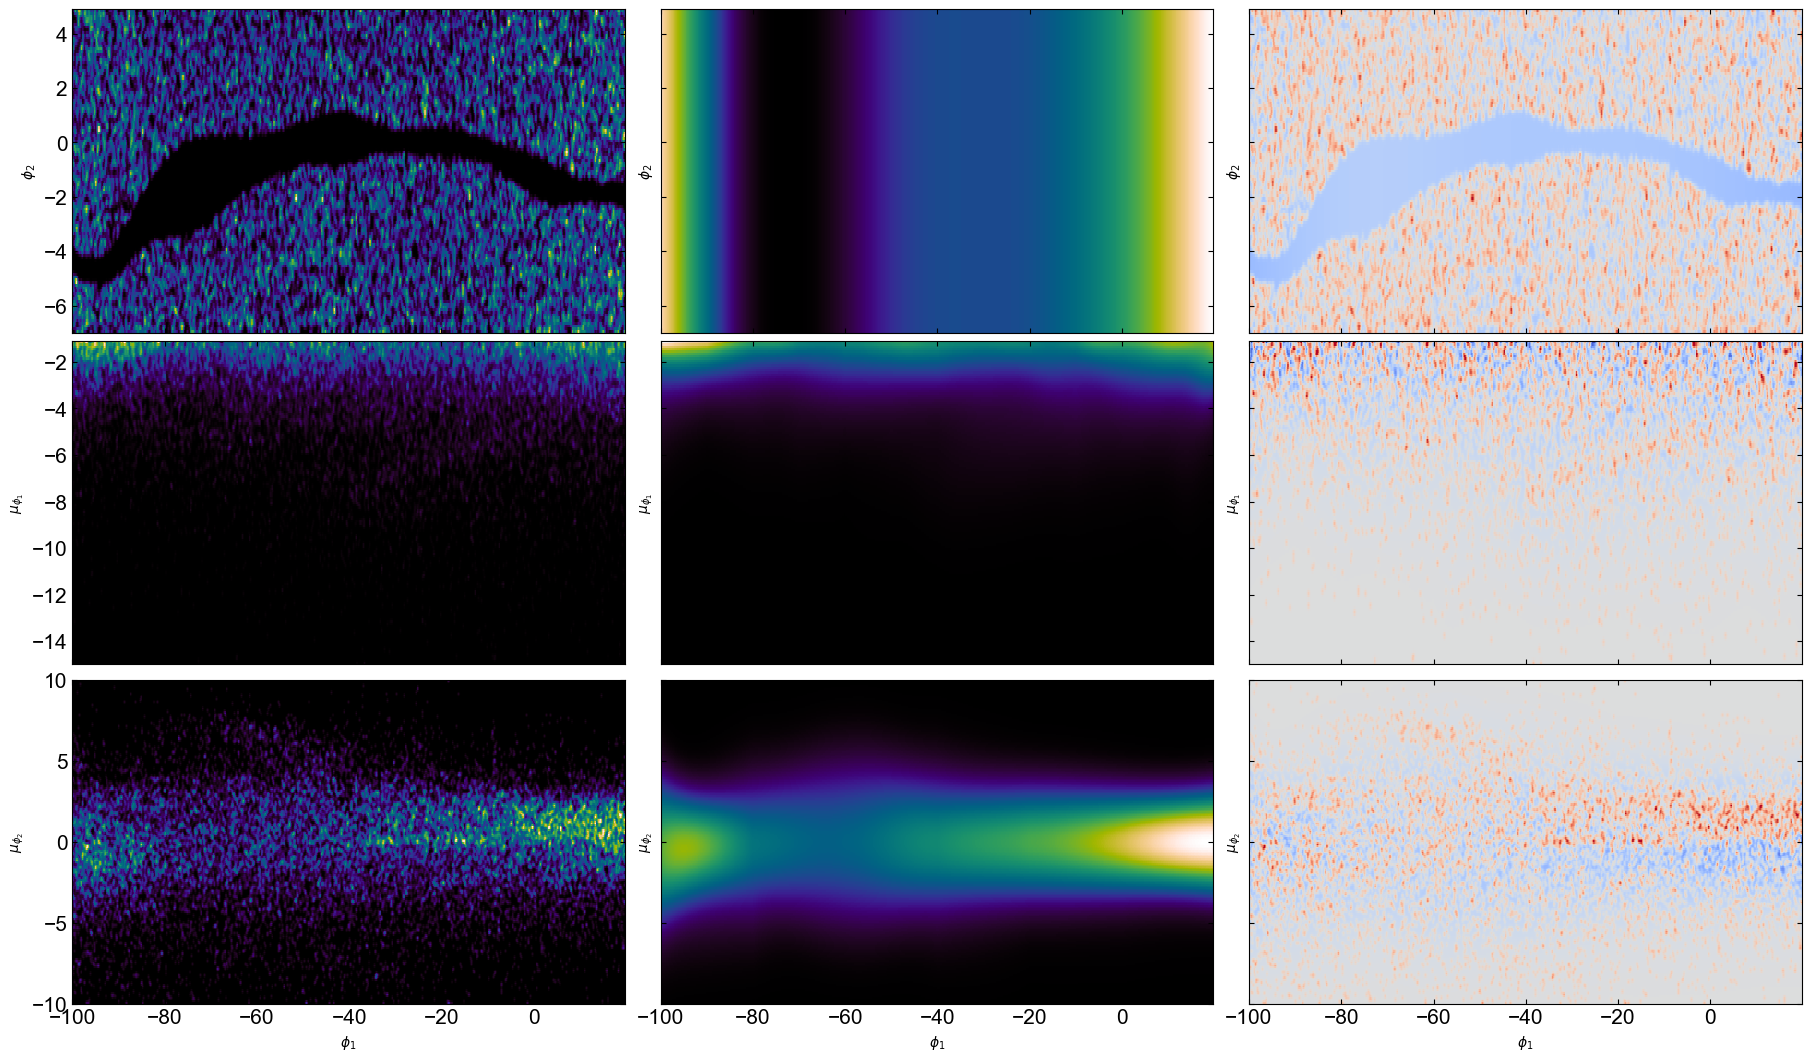

In [36]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Stream

In [196]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-90, 10, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [197]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

In [198]:
np.e**10

22026.465794806703

In [199]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(GD1StreamModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(GD1StreamModel.phi2_knots),
        "ln_std": np.full_like(GD1StreamModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(GD1StreamModel.pm1_knots),
        "ln_std": np.full_like(GD1StreamModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(GD1StreamModel.pm2_knots),
        "ln_std": np.full_like(GD1StreamModel.pm2_knots, -1)
    }
}

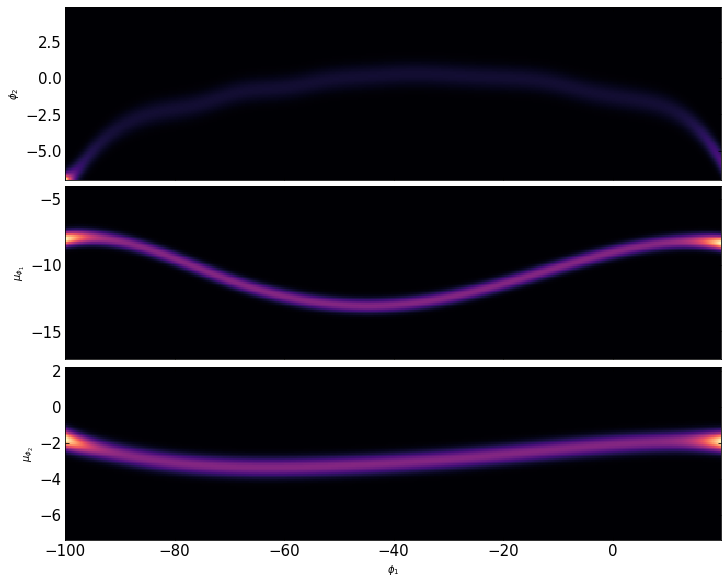

In [200]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [201]:
stream_init_p

{'ln_N': 7.330405211844402,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-7.88163477, -3.95341163, -2.42211648, -1.84441857, -0.95850907,
         -0.65285416, -0.1239385 ,  0.14401882,  0.29575805,  0.15567152,
          0.0156095 , -0.25665396, -0.97954984, -1.47919275, -2.45582047,
         -5.90023171]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
         -0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm1': {'mean': array([ -8.01001683,  -8.77103682, -11.15172534, -12.76884806,
         -13.02597314, -11.97714148, -10.18789348,  -8.59629564,
          -8.319378  ]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-1.80139711, -3.24562547, -3.27612746, -2.78970843, -2.09902309,
         -1.99723637]),
  'ln_std': array([-1., -1., -1., -1., -1., -1.])}}

In [202]:
stream_opt_pars, info = GD1StreamModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = GD1StreamModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.70121455, dtype=float64, weak_type=True), success=True, status=0, iter_num=948, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.12444592e-05  1.15912023e-04
  -4.11806358e-04 -3.08258798e-06  3.12536600e-04  5.20739987e-04
  -1.56488154e-04 -1.16033348e-05  2.08631559e-04  2.83054139e-05
  -3.31902311e-04 -4.49643708e-05  1.36171899e-05 -1.84241189e-04
  -4.63823726e-05 -4.67812304e-04 -5.39482336e-04  6.97212649e-05
   5.80945881e-05 -5.85459822e-04 -2.70417207e-04  0.00000000e+00
   1.99812507e-04  8.99373808e-05  2.10908627e-05  3.53583625e-06
   3.80426351e-07  7.45146247e-05  1.89953641e-05  7.04911538e-05
  -4.46152029e-07  1.98672567e-05 -5.35569311e-06  1.90893192e-05
   3.61888890e-05  7.21096489e-06  6.05582650e-07  4.53079943e-05
   4.80289059e-05 -8.42180797e-06 -2.19351860e-05 -1.05525166e-05
  -4.39214413e-05  3.81711565e-05  1.20218667e-05 -5.02387495

Text(0, 0.5, '$\\phi_2$')

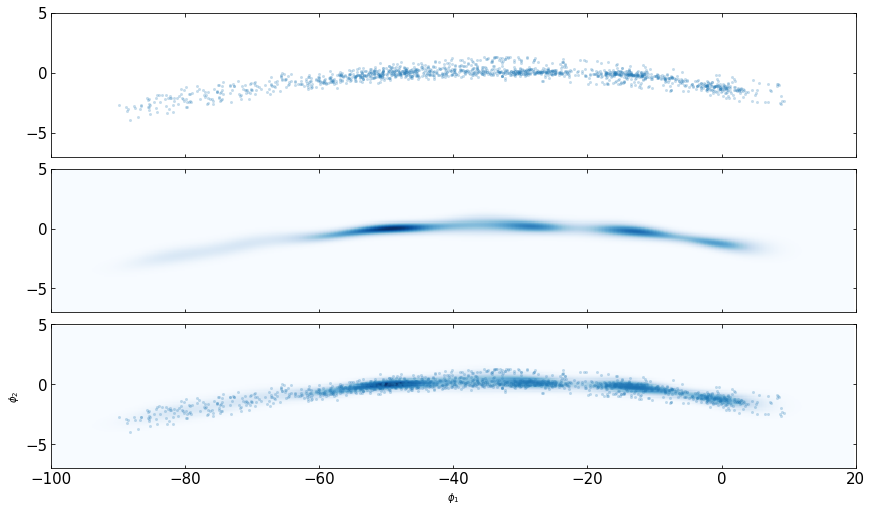

In [203]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

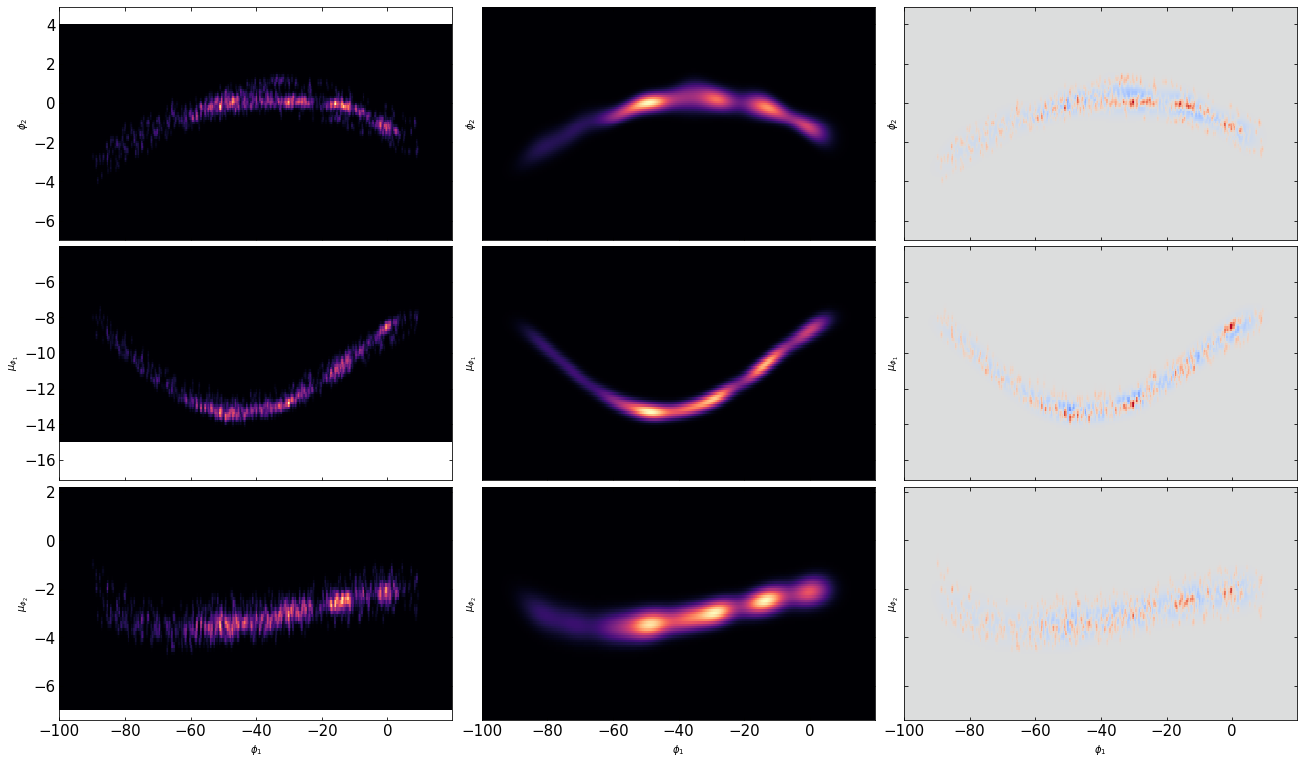

In [204]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [205]:
Components = [GD1StreamModel, GD1BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [206]:
mix_init = StreamMixtureModel(mix_params0, Components)

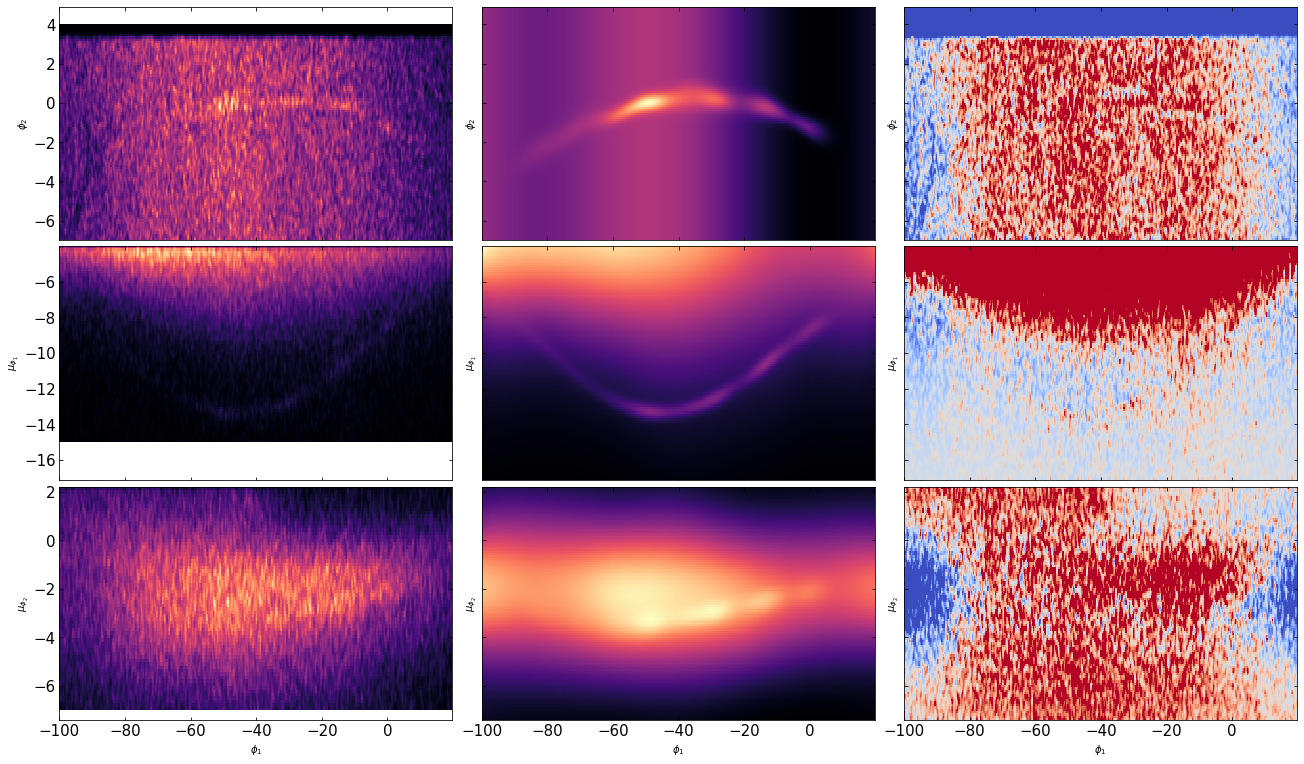

In [207]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [208]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(1.11735319, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]))

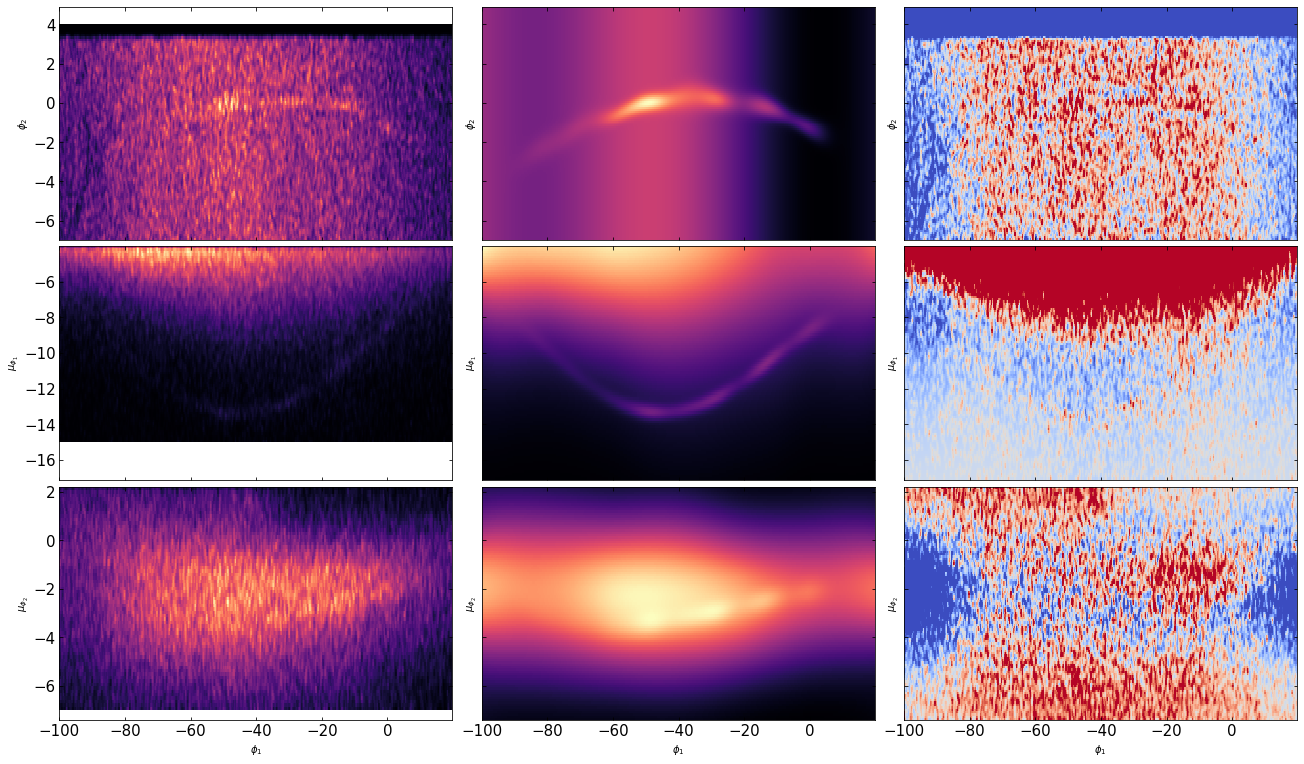

In [209]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [211]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(GD1OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

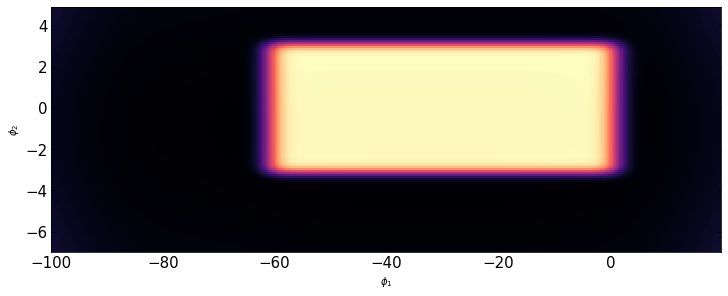

In [212]:
offtrack_model0 = GD1OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [213]:
full_Components = [GD1StreamModel, GD1BackgroundModel, GD1OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [214]:
full_mix_init = StreamMixtureModel(
    full_mix_params0,
    full_Components,
    tied_params=[
        (("offtrack", "pm1"), ("stream", "pm1")),
        (("offtrack", "pm2"), ("stream", "pm2")),
    ],
)

In [ ]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

In [ ]:
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

In [ ]:
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5))

In [217]:
full_mix_opt_pars['stream']['pm1']

{'ln_std': Array([-0.86541515, -0.91688066, -1.06186763, -1.15438145, -1.25354065,
        -1.14996269, -1.09284736, -0.96356562, -0.96085753], dtype=float64),
 'mean': Array([ -8.23973304,  -9.00712161, -11.39111032, -13.03184141,
        -13.23629789, -12.15145871, -10.11117072,  -8.23814473,
         -8.53670427], dtype=float64)}

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

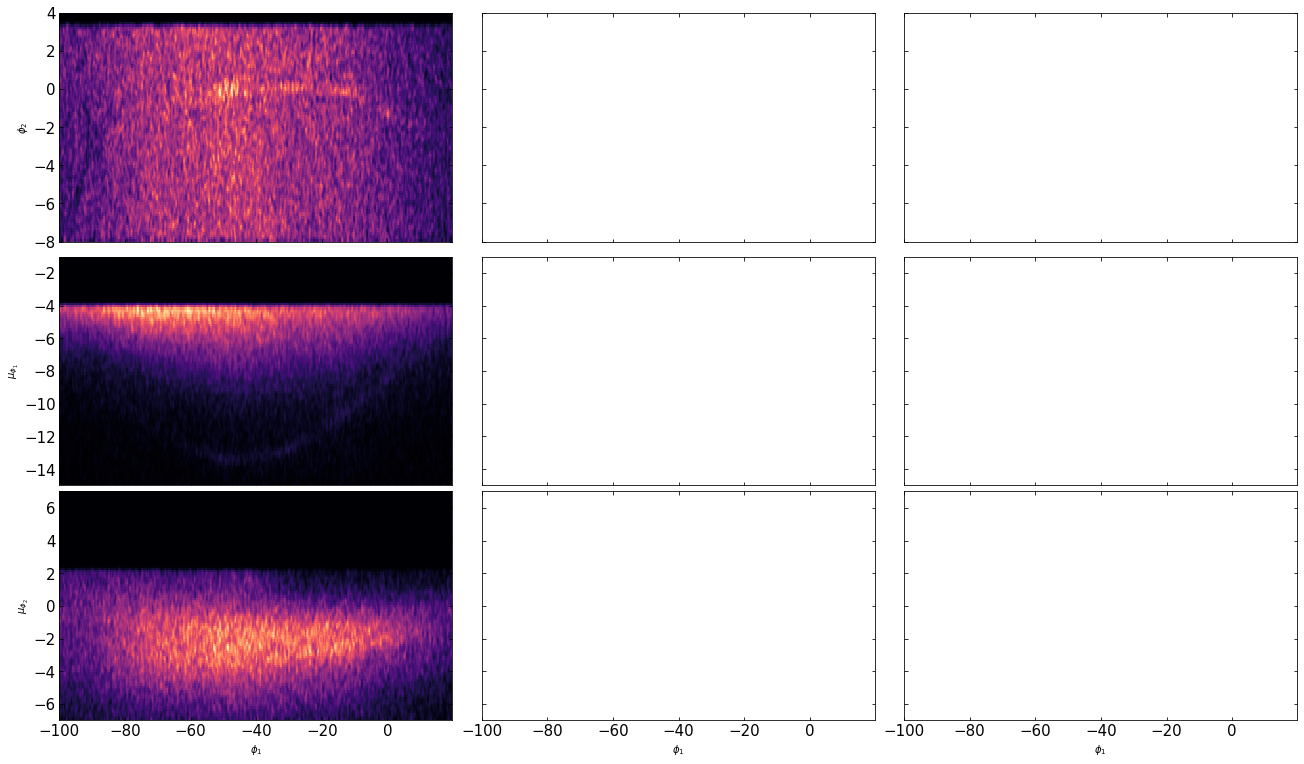

In [221]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")